In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# ML相关库
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures,StandardScaler
from sklearn.model_selection import KFold,GridSearchCV,train_test_split,RandomizedSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

# DL相关库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from model import TimeSeriesTransformer

# 设置随机数种子
torch.manual_seed(666)

# 绘图全局设置
from pylab import mpl,plt
plt.style.use('seaborn')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [24]:
raw=pd.read_csv('demo.csv',index_col=0)
raw.index=pd.DatetimeIndex(raw.index)
name_map_cn={'Heilongjiang': '黑龙江省', 'Jilin': '吉林省', 'Liaoning': '辽宁省', 'Beijing': '北京市', 
            'Tianjin': '天津市', 'Hebei': '河北省', 'Shanxi': '山西省', 'Inner Mongolia': '内蒙古自治区', 
            'Shanghai': '上海市', 'Jiangsu': '江苏省', 'Shandong': '山东省', 'Zhejiang': '浙江省', 
            'Anhui': '安徽省', 'Jiangxi': '江西省', 'Fujian': '福建省', 'Guangdong': '广东省', 
            'Macau': '澳门特别行政区', 'Taiwan': '台湾省', 'Hong Kong': '香港特别行政区', 'Tibet': '西藏自治区', 
            'Guangxi': '广西省', 'Hainan': '海南省', 'Henan': '河南省', 'Hubei': '湖北省', 'Hunan': '湖南省', 
            'Shaanxi': '陕西省', 'Xinjiang': '新疆自治区', 'Ningxia': '宁夏自治区', 'Gansu': '甘肃省', 
            'Qinghai': '青海省', 'Chongqing': '重庆市', 'Sichuan': '四川省', 'Guizhou': '贵州省', 'Yunnan': '云南省',}

raw.rename(columns=name_map_cn,inplace=True)
data=raw.loc['2022-11':,['安徽省','北京市']]
data

,安徽省,北京市
2022-11-01,1538,4756
2022-11-02,1538,4823
2022-11-03,1539,4861
2022-11-04,1539,4902
2022-11-05,1539,4951
...,...,...
2023-03-05,2275,40774
2023-03-06,2275,40774
2023-03-07,2275,40774
2023-03-08,2275,40774


In [3]:
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model,max_seq_len=5000,dropout=0.1,batch_first=False) -> None:
#         '''不知道为什么，d_model必须是偶数'''
#         super().__init__()
#         self.x_dim=1 if batch_first else 0
#         self.batch_first=batch_first
#         pos=torch.arange(0,max_seq_len).unsqueeze(1)
#         div_term=torch.pow(10000,torch.arange(0,d_model,2)/d_model)
        
#         if self.batch_first:
#             pe=torch.zeros(1,max_seq_len,d_model)
#             pe[0,:,0::2]=torch.sin(pos/div_term)
#             pe[0,:,1::2]=torch.cos(pos/div_term)
#         else:
#             pe=torch.zeros(max_seq_len,1,d_model)
#             pe[:,0,0::2]=torch.sin(pos/div_term)
#             pe[:,0,1::2]=torch.cos(pos/div_term)
#         self.register_buffer('pe', pe)
#         self.dropout=nn.Dropout(dropout)

#     def forward(self,x):
#         if self.batch_first:
#             x=x+self.pe[:,:x.shape[self.x_dim]]
#         else:
#             x=x+self.pe[:x.shape[self.x_dim]]
#         return self.dropout(x)

# class TimeSeriesTransformer(nn.Module):
#     def __init__(self,nvars,d_model,d_hid,nheads,nlayers,dropout=0.1) -> None:
#         '''把d_modal与变量个数做映射
#         '''
#         super().__init__()
#         self.model_name='Transformer Encoder'
#         # self.max_seq_len=train_win

#         # encoder
#         self.encoder_input_mapping=nn.Linear(nvars,d_model)
#         self.pos_encoding=PositionalEncoding(d_model=d_model,batch_first=True)
#         encoder_layer=nn.TransformerEncoderLayer(d_model,nheads,d_hid,dropout,batch_first=True)
#         self.transformer_encoder=nn.TransformerEncoder(encoder_layer,num_layers=nlayers,norm=None)
#         #norm参数表示每个encoder_layer所需的normalization方法，但是nn.TransformerEncoderLayer已经包含了Layer-normalization，故不需要向norm传递参数，事实上，norm参数是为不具备normalization方法的custorm encoder-layers准备的。
        
#         # decoder
#         self.decoder_input_mapping=nn.Linear(nvars,d_model)
#         decoder_layer=nn.TransformerDecoderLayer(d_model=d_model,nhead=nheads,dim_feedforward=d_hid,dropout=dropout,batch_first=True)
#         self.transformer_decoder=nn.TransformerDecoder(decoder_layer,num_layers=nlayers,norm=None)
#         self.decoder_output_mapping=nn.Linear(d_model,nvars)

#         # 初始化参数
#         self.init_weight()
    
#     def init_weight(self):
#         init_range=0.1
#         self.encoder_input_mapping.weight.data.uniform_(-init_range,init_range)
#         self.encoder_input_mapping.bias.data.zero_()

#         self.decoder_input_mapping.weight.data.uniform_(-init_range,init_range)
#         self.decoder_input_mapping.bias.data.zero_()

#         self.decoder_output_mapping.weight.data.uniform_(-init_range,init_range)
#         self.decoder_output_mapping.bias.data.zero_()

#     def forward(self,src,tgt,memory_mask=None,tgt_mask=None):
#         '''
#         Return a tensor of shape:
#         [batch_size,tgt_win,nvars]
#         Args:
#             src:[batch_size,train_win,nvars]
#             tgt:[batch_size,tgt_win,nvars]
#             memory_mask:[train_win,train_win]
#             tgt_mask:[tgt_win,tgt_win]
#         '''
#         # encoder
#         src=self.encoder_input_mapping(src)
#         src=self.pos_encoding(src)
#         encoder_output=self.transformer_encoder(src)

#         # decoder
#         tgt=self.decoder_input_mapping(tgt)
#         decoder_output=self.transformer_decoder(tgt=tgt,memory=encoder_output,tgt_mask=tgt_mask,memory_mask=memory_mask)#memory：最后一层encoder layer的输出
#         decoder_output=self.decoder_output_mapping(decoder_output)
#         return decoder_output

In a typical training setup, we train the model to predict 4 future weekly ILI ratios from 10 trailing weekly datapoints. That is, given the encoder input (x1, x2, …, x10) and the decoder input (x10, …, x13), the decoder aims to output (x11, …, x14). ([2] page 5)

In [25]:
class ML_predict:
    def __init__(self,series:pd.Series,train_win,tgt_win) -> None:
        self.series=series
        self.train_win=train_win
        self.tgt_win=tgt_win

    def gen_seq_tgt(self):
        '''生成滞后项，np.ndarray'''
        src,tgt=[],[]
        L=len(self.series)
        for i in range(L-self.train_win-self.tgt_win):
            src.append(self.series.iloc[i:i+self.train_win].values)
            tgt.append(self.series.iloc[i+self.train_win:i+self.train_win+self.tgt_win].values)

        # 用于后续绘图
        self.time_index=self.series.index
        self.src=torch.Tensor(np.array(src))
        self.tgt=torch.Tensor(np.array(tgt))
    
    def predict(self,model,test_size,batch_size=None):
        self.model_name=str(model).split('(')[0]
        xtrain,xtest,ytrain,ytest=train_test_split(self.src,self.tgt,test_size=test_size,shuffle=False)

        model.fit(xtrain,ytrain)
        pred=model.predict(xtest)
        
        mse,mae,mape=mean_squared_error(ytest,pred),mean_absolute_error(ytest,pred),mean_absolute_percentage_error(ytest,pred)
        score={'MSE':round(mse,3),'MAE':round(mae,3),'MAPE':round(mape,3)}

        return pred,score
    
    def plot(self,pred):

        fig=plt.figure(figsize=(10,5))
        plt.plot(self.time_index,self.series,label='true values')

        length_test=pred.shape[0]
        pred_idx=self.time_index[-length_test:]
        plt.plot(pred_idx,pred,label='predictions')
        plt.vlines(pred_idx[0],ymin=self.src[:,0].min(),ymax=self.src[:,0].max(),colors='k',linestyles='dashed',alpha=0.3)
        plt.vlines(pred_idx[-1],ymin=self.src[:,0].min(),ymax=self.src[:,0].max(),colors='k',linestyles='dashed',alpha=0.3)
        # plt.text(pred_idx[0],pred[0],s=f'{pred_idx[0]}')
        plt.legend(fontsize=16)
        plt.title(f"{self.model_name}",fontsize=20)
        # plt.title(f"{self.model_name} MSE:{score['MSE']:.3f} MAE:{score['MAE']:.3f} MAPE:{score['MAPE']:.3f}",fontsize=20)

    def __call__(self,model,test_size,batch_size=None):
        self.gen_seq_tgt()
        pred,score=self.predict(model,test_size,batch_size)
        self.plot(pred)
        return score


class DL_predict(ML_predict):
    def __init__(self,series: pd.Series,train_win, tgt_win) -> None:
        super().__init__(series,train_win, tgt_win)

    def gen_seq_tgt(self):
        '''生成滞后项，np.ndarray'''
        src,tgt,tgt_y=[],[],[]
        L=len(self.series)
        for i in range(L-self.train_win-self.tgt_win):
            src.append(self.series.iloc[i : i + self.train_win].values)
            tgt.append(self.series.iloc[i + self.train_win - 1 : i + self.train_win + self.tgt_win -1].values)
            tgt_y.append(self.series.iloc[i + self.train_win : i + self.train_win + self.tgt_win].values)

        # 用于后续绘图
        self.time_index=self.series.index
        self.src=torch.Tensor(np.array(src)).unsqueeze(2)
        self.tgt=torch.Tensor(np.array(tgt)).unsqueeze(2)
        self.tgt_y=torch.Tensor(np.array(tgt_y)).unsqueeze(2)

    def predict(self, model,test_size,batch_size):
        self.model_name=str(model).split('(')[0]

        # 划分数据集并构造dataset与dataloader
        xtrain,xtest,tgttrain,tgttest,ytrain,ytest=train_test_split(self.src,self.tgt,self.tgt_y,test_size=test_size,shuffle=False)
        train_ds=TensorDataset(torch.Tensor(xtrain),torch.Tensor(tgttrain),torch.Tensor(ytrain))
        train_dl=DataLoader(train_ds,batch_size=batch_size)

        # 训练
        criterion=nn.MSELoss()
        optimizer=torch.optim.Adam(model.parameters(),lr=1)
        tgt_mask=self.gen_square_subsequent_mask(self.tgt_win,self.tgt_win)
        memory_mask=self.gen_square_subsequent_mask(self.tgt_win,self.train_win)
        model.train()
        for epoch in range(1):
            print(f"epoch: {epoch+1}")
            print('-'*100)
            pbar=tqdm(train_dl)
            for src,tgt,tgt_y in pbar:
                tgt_pred=model(src,tgt,tgt_mask=tgt_mask,memory_mask=memory_mask)
                loss=criterion(tgt_pred,tgt_y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                pbar.set_postfix_str(f'当前batch的loss为：{loss.item():.3f}')

        # 推理并计算metric
        model.eval()
        with torch.no_grad():
            pred=model(xtest,tgttest,tgt_mask=tgt_mask,memory_mask=memory_mask).detach().numpy()

            # 多变量时间预测
            mse,mae,mape=0,0,0
            for nvar in range(pred.shape[-1]):
                mse+=mean_squared_error(ytest[:,:,nvar],pred[:,:,nvar])
                mae+=mean_absolute_error(ytest[:,:,nvar],pred[:,:,nvar])
                mape+=mean_absolute_percentage_error(ytest[:,:,nvar],pred[:,:,nvar])
                score={'MSE':round(mse,3),'MAE':round(mae,3),'MAPE':round(mape,3)}
            return pred.squeeze(1),score
        
    def gen_square_subsequent_mask(self,dim1,dim2):
        '''
        Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
        Return:
            A Tensor of shape [dim1, dim2]
        '''
        return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)
        # return torch.triu(torch.ones(dim1,dim2),diagonal=1).to(torch.bool)#这种计算mask的方式不行

train_win=5
tgt_win=1
test_size=0.2  
batch_size=4 

In [5]:
temp=pd.read_csv('dfs_merged_upload.csv',index_col=0)
temp.index=pd.DatetimeIndex(temp['timestamp'])
target_col_name='FCR_N_PriceEUR'

epoch: 1
----------------------------------------------------------------------------------------------------


100%|██████████| 25/25 [00:00<00:00, 27.91it/s, 当前batch的loss为：9879.806]  


{'MSE': 49263.84, 'MAE': 221.955, 'MAPE': 0.098}

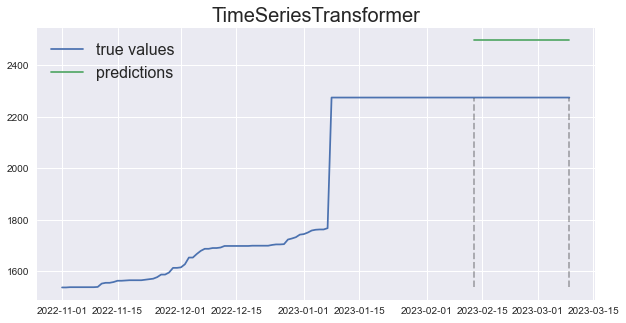

In [26]:
target_col_name='安徽省'
model=TimeSeriesTransformer(
    nvars=1,
    d_model=512,
    d_hid=128,
    nheads=8,
    nlayers=2,
    dropout=0.1
)
te=DL_predict(data.loc['2022-3-15':,target_col_name],train_win,tgt_win)
te(model,0.2,4)

/Users/singal/miniforge3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


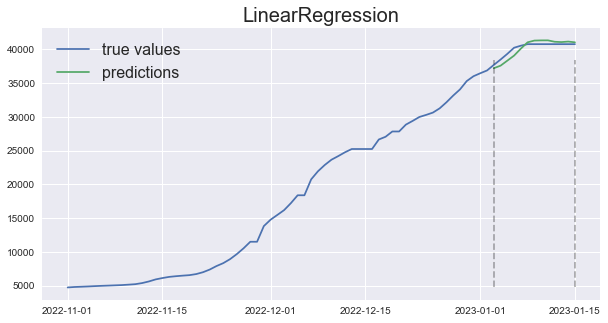

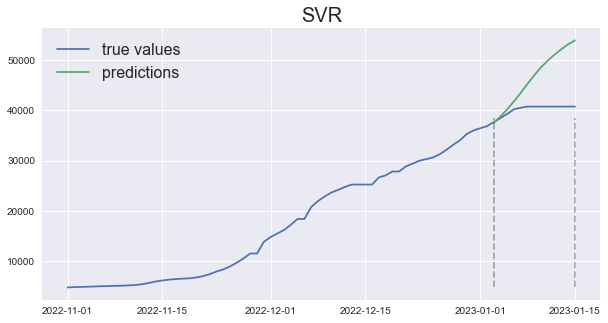

In [285]:
model=LinearRegression()
lr=ML_predict(data.loc[:'2023-1-15','北京市'],train_win=train_win,tgt_win=tgt_win)
lr_score=lr(model,test_size)

model=SVR(kernel='poly')
svr=ML_predict(data.loc[:'2023-1-15','北京市'],train_win=train_win,tgt_win=tgt_win)
svr_score=svr(model,test_size)